# Dialect Identification using a Bert-based model

- [Bert Model](https://huggingface.co/UBC-NLP/MARBERTv2)

## Download Data

In [ ]:
!wget https://cdn.discordapp.com/attachments/778630432878362676/934217772664258560/MultiTest.rar
!wget https://cdn.discordapp.com/attachments/778630432878362676/934217856114122752/MultiDev.rar
!wget https://cdn.discordapp.com/attachments/778630432878362676/934217865811349504/MultiTrain.Shuffled.rar

--2023-04-10 12:46:04--  https://cdn.discordapp.com/attachments/778630432878362676/934217772664258560/MultiTest.rar

Resolving cdn.discordapp.com (cdn.discordapp.com)... 162.159.129.233, 162.159.134.233, 162.159.130.233, ...

Connecting to cdn.discordapp.com (cdn.discordapp.com)|162.159.129.233|:443... connected.

HTTP request sent, awaiting response... 200 OK

Length: 547942 (535K) [application/rar]

Saving to: ‘MultiTest.rar’



MultiTest.rar       100%[===================>] 535.10K  --.-KB/s    in 0.05s   



2023-04-10 12:46:05 (11.1 MB/s) - ‘MultiTest.rar’ saved [547942/547942]



--2023-04-10 12:46:05--  https://cdn.discordapp.com/attachments/778630432878362676/934217856114122752/MultiDev.rar

Resolving cdn.discordapp.com (cdn.discordapp.com)... 162.159.129.233, 162.159.134.233, 162.159.130.233, ...

Connecting to cdn.discordapp.com (cdn.discordapp.com)|162.159.129.233|:443... connected.

HTTP request sent, awaiting response... 200 OK

Length: 521431 (509K) [application/rar]

Sav

In [ ]:
!unrar x "/content/MultiDev.rar" "/content/Data/"
!unrar x "/content/MultiTest.rar" "/content/Data/"
!unrar x "/content/MultiTrain.Shuffled.rar" "/content/Data/"



UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal





Extracting from /content/MultiDev.rar



Creating    /content/Data                                             OK

Extracting  /content/Data/MultiDev.csv                                    1 1 2 3 3 4 5 5 6 6 7 8 8 9 99  OK 

All OK



UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal





Extracting from /content/MultiTest.rar



Extracting  /content/Data/MultiTest.csv                                   1 1 2 2 3 4 4 5 5 6 7 7 8 8 9 99  OK 

All OK



UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal





Extracting from /content/MultiTrain.Shuffled.rar



Extracting  /content/Data/MultiTrain.Shuffled.csv                                           1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 99  OK 

All OK


## Imports

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 42.5 MB/s eta 0:00:00



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.5 MB/s eta 0:00:00










     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 9.0 MB/s eta 0:00:00









In [ ]:
!pip install transformers-interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 KB 3.0 MB/s eta 0:00:00





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.9 MB/s eta 0:00:00






     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.9 MB/s eta 0:00:00















































In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW,BertTokenizerFast,Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader
import re
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score
from transformers_interpret import SequenceClassificationExplainer

## Read and clean data

In [ ]:
train = pd.read_csv("/content/Data/MultiTrain.Shuffled.csv")
val = pd.read_csv("/content/Data/MultiDev.csv")
test = pd.read_csv("/content/Data/MultiTest.csv")

In [ ]:
train.head()

,Unnamed: 0,label,text
0,0,MSA,بالإضافة لقيام معلمو الجيزة للذهاب إلي جريدة ا...
1,1,MSA,بعدين والله حرام تجي تلقى الي واقف عند الاشاره...
2,2,DIAL_LEV,لمسه اليد مرتين واضحة جدا والحكم
3,3,DIAL_LEV,بخصوص الهاتريك عمرها ما راح تصير
4,4,DIAL_GLF,الله يجبر كسرهم ويرجع و لدهم اليوم قبل بكرى ،


In [ ]:
test.head()

,Unnamed: 0,label,text
0,0,DIAL_EGY,ياراجل فن ايه هوه ده فن دي قلة
1,1,DIAL_EGY,حاجة تكسف مش كفاية روبى كمان
2,2,DIAL_EGY,اللهم صبرنا على ما ابتليتنا به مناظركم دى هى ا...
3,3,DIAL_EGY,ارحمونه الفن خرب من الاقارب والعالم
4,4,DIAL_EGY,ارحمونه الفن خرب من الاقارب والعالم


In [ ]:
val.head()

,Unnamed: 0,label,text
0,0,DIAL_EGY,تصور كل ده كله . . تلاقيني باحبك أكتر .
1,1,DIAL_EGY,أكتر من روحي باحبك .
2,2,DIAL_EGY,وتصور حب المخلص لحبيبه اللي ولا بأيه يتغير .
3,3,DIAL_EGY,تصور كل ده كله . . تلاقيني باحبك أكتر .
4,4,DIAL_EGY,أكتر من روحي باحبك . . بحقيقي باحبك أكتر .


In [ ]:
train.drop(columns=['Unnamed: 0'],inplace=True)
val.drop(columns=['Unnamed: 0'],inplace=True)
test.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
train = train.astype(str)
test = test.astype(str)
val = val.astype(str)

In [ ]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)
val.drop_duplicates(inplace=True)

In [ ]:
class preprocessing:

  def normalize(sentence):
    '''
    Argument:
        string of words
    return:
        string of words but standardize the words
    '''
    sentence = re.sub("[إأآا]", "ا", sentence)
    sentence = re.sub("ى", "ي", sentence)
    sentence = re.sub("ؤ", "ء", sentence)
    sentence = re.sub("ئ", "ء", sentence)
    sentence = re.sub("ة", "ه", sentence)
    sentence = re.sub("گ", "ك", sentence)
    return sentence

  def remove_punkt(sentence):
    '''
      Argument:
          string of words
      return:
          string of words but after removing punctuations
    '''
    text = re.sub(r'[^\w\s]',"",sentence)
    return text

  def preprocess(sentence):
    '''
    Argument:
        string of words
    return:
        string of words after cleaning
    '''
    clean = preprocessing.normalize(sentence)
    clean = preprocessing.remove_punkt(clean)
    return clean

In [ ]:
train['text'] = train['text'].apply(preprocessing.preprocess)
test['text'] = test['text'].apply(preprocessing.preprocess)
val['text'] = val['text'].apply(preprocessing.preprocess)

In [ ]:
train.head()

,label,text
0,MSA,بالاضافه لقيام معلمو الجيزه للذهاب الي جريده ا...
1,MSA,بعدين والله حرام تجي تلقي الي واقف عند الاشاره...
2,DIAL_LEV,لمسه اليد مرتين واضحه جدا والحكم
3,DIAL_LEV,بخصوص الهاتريك عمرها ما راح تصير
4,DIAL_GLF,الله يجبر كسرهم ويرجع و لدهم اليوم قبل بكري


In [ ]:
train['label'].value_counts()

MSA         45360
DIAL_GLF    16135
DIAL_EGY     9440
DIAL_LEV     8822
Name: label, dtype: int64

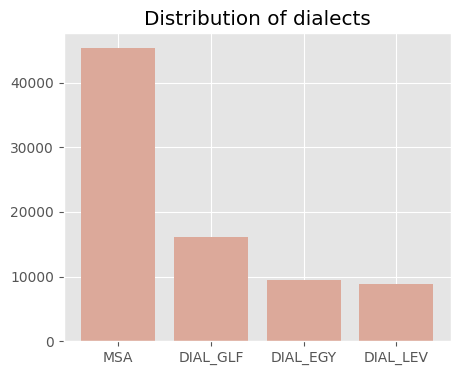

In [ ]:
fig = plt.figure(figsize =(5, 4))
plt.bar(train['label'].value_counts().index, train['label'].value_counts(),color ='#DCA99A');
plt.title("Distribution of dialects");

## Prepare Data and model

In [ ]:
train['label'] = train['label'].map({'MSA': 0, 'DIAL_LEV': 1, 'DIAL_GLF': 2, 'DIAL_EGY': 3})
val['label'] = val['label'].map({'MSA': 0, 'DIAL_LEV': 1, 'DIAL_GLF': 2, 'DIAL_EGY': 3})
test['label'] = test['label'].map({'MSA': 0, 'DIAL_LEV': 1, 'DIAL_GLF': 2, 'DIAL_EGY': 3})

In [ ]:
train.head()

,label,text
0,0,بالاضافه لقيام معلمو الجيزه للذهاب الي جريده ا...
1,0,بعدين والله حرام تجي تلقي الي واقف عند الاشاره...
2,1,لمسه اليد مرتين واضحه جدا والحكم
3,1,بخصوص الهاتريك عمرها ما راح تصير
4,2,الله يجبر كسرهم ويرجع و لدهم اليوم قبل بكري


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('UBC-NLP/MARBERTV2', num_labels=len(train['label'].unique()))
tokenizer = BertTokenizerFast.from_pretrained('UBC-NLP/MARBERTV2')

Some weights of the model checkpoint at UBC-NLP/MARBERTV2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']

- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

Some weights of BertForSequenceClassification were not initi

### Encode text & prepare dataloader

In [ ]:
train_encodings = tokenizer(train['text'].to_list(), truncation=True, padding=True, max_length=60)
val_encodings = tokenizer(val['text'].to_list(), truncation=True, padding=True, max_length=60)
test_encodings = tokenizer(test['text'].to_list(), truncation=True, padding=True, max_length=60)

In [ ]:
train_labels = train['label']
val_labels = val['label']
test_labels = test['label']

In [ ]:
class DialectsDataset(Dataset):
  def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels.to_list()

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def __len__(self):
      return len(self.labels)

In [ ]:
ds_train = DialectsDataset(train_encodings, train_labels)
ds_val =  DialectsDataset(val_encodings, val_labels)
ds_test =  DialectsDataset(test_encodings, test_labels)

### Training Arguments

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  acc = accuracy_score(labels, predictions)
  return {
      'accuracy': acc,
  }

In [ ]:
training_args = TrainingArguments(
    output_dir='results',          
    num_train_epochs=2,              
    per_device_train_batch_size=64, 
    per_device_eval_batch_size=32,       
    evaluation_strategy = "epoch",        
    save_strategy = 'epoch',
    )

trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=ds_train,
    eval_dataset=ds_val,                       
    compute_metrics=compute_metrics
)

## Training

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.427300,0.408993,0.855341
2,0.270600,0.424693,0.864671


TrainOutput(global_step=2494, training_loss=0.36706680016414395, metrics={'train_runtime': 1649.0334, 'train_samples_per_second': 96.732, 'train_steps_per_second': 1.512, 'total_flos': 4918435610886720.0, 'train_loss': 0.36706680016414395, 'epoch': 2.0})

## Testing

In [ ]:
preds = trainer.predict(ds_test)

In [ ]:
y_pred = [np.argmax(i, axis=-1) for i  in preds.predictions]
y_test = ds_test.labels

In [ ]:
accuracy_score(y_test, y_pred)

0.8593887315691827

## Interpretability tool 
- Captum: https://github.com/pytorch/captum

- transformers-interpret: https://github.com/cdpierse/transformers-interpret

- Lime: https://github.com/marcotcr/lime

- GradCam: https://github.com/jacobgil/pytorch-grad-cam

In [ ]:
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)

def interpret(explainer,text,TrueClass,name):
  word_attributions = explainer(text)
  explainer.visualize(name,true_class=TrueClass)
  return word_attributions

In [ ]:
word_attributions = interpret(cls_explainer," ودمك زي السكر",3,'exp')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_3 (0.85),LABEL_3,1.29,[CLS] ودمك زي السكر [SEP]


In [ ]:
word_attributions = interpret(cls_explainer,"شو بدك فيني",1,'exp')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.99),LABEL_1,1.11,[CLS] شو بدك فيني [SEP]


## Lab Task
- Use this [BERT model](https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter) to build a sentiment analysis system. 

- Dataset you will use is provided in the lab files [
ASAD: A Twitter-Based Benchmark Arabic Sentiment Analysis Dataset](https://arxiv.org/pdf/2011.00578.pdf)
- Make sure to **Not remove Emotions**

In [1]:
!pip install transformers datasets
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np
from torch import nn
import torch
from sklearn.metrics import f1_score
from datasets import Dataset
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.7 MB/s eta 0:00:00


In [23]:
# Import dataset
dataset = pd.read_csv("sentiment_data.csv")
dataset.head()

,text,sentiment
0,@nas_alharbi8 والله حسب الأرقام سيكون مخيب للآ...,Positive
1,"""الزعل بيغير ملامحك ، بيغير نظرة العين ، بيغير...",Neutral
2,الحب الحقيقي هو اقتسام بعض نفسك مع شخص أخر أقر...,Positive
3,@Mo_Fat7 النهضة في فتيل 😂,Positive
4,@halgawi @DmfMohe ليس حباً في ايران بقدر ماهو ...,Neutral


In [24]:
# HF Transformers expect the target column name as "labels"
dataset = dataset.rename(columns={"sentiment":"labels"})

In [25]:
# Clean text
class preprocessing:

  def normalize(sentence):
    '''
    Argument:
        string of words
    return:
        string of words but standardize the words
    '''
    sentence = re.sub("[إأآا]", "ا", sentence)
    sentence = re.sub("ى", "ي", sentence)
    sentence = re.sub("ؤ", "ء", sentence)
    sentence = re.sub("ئ", "ء", sentence)
    sentence = re.sub("ة", "ه", sentence)
    sentence = re.sub("گ", "ك", sentence)
    return sentence

  def clean(sentence):
    '''
      Argument:
          string of words
      return:
          string of words but after removing punctuations
    '''
    sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)
    sentence = sentence.replace('\n',' ').strip()
    sentence = re.sub(r'[^\w\s]',"",sentence)
    return sentence

  def preprocess(sentence):
    '''
    Argument:
        string of words
    return:
        string of words after cleaning
    '''
    sentence = preprocessing.clean(sentence)
    sentence = preprocessing.normalize(sentence)
    return sentence

In [5]:
# Clean text
dataset['text'] = dataset['text'].apply(preprocessing.preprocess)
dataset.head()

,text,labels
0,والله حسب الارقام سيكون مخيب للامال ولكن الاهل...,Positive
1,الزعل بيغير ملامحك بيغير نظره العين بيغير شك...,Neutral
2,الحب الحقيقي هو اقتسام بعض نفسك مع شخص اخر اقر...,Positive
3,النهضه في فتيل,Positive
4,ليس حبا في ايران بقدر ماهو نكايه بترامب وحزبه,Neutral


In [6]:
dataset.labels.value_counts()

Neutral     37359
Positive     8821
Negative     8820
Name: labels, dtype: int64

In [38]:
dataset.isna().sum()

text      0
labels    1
dtype: int64

In [39]:
dataset.dropna(inplace=True)
dataset

,text,labels
0,@nas_alharbi8 والله حسب الأرقام سيكون مخيب للآ...,2.0
1,"""الزعل بيغير ملامحك ، بيغير نظرة العين ، بيغير...",1.0
2,الحب الحقيقي هو اقتسام بعض نفسك مع شخص أخر أقر...,2.0
3,@Mo_Fat7 النهضة في فتيل 😂,2.0
4,@halgawi @DmfMohe ليس حباً في ايران بقدر ماهو ...,1.0
...,...,...
54996,#تصنيف_دايم_للتخصصات_الصحيه٥ بالامس تحدثونا عن...,1.0
54997,@MCgovSA اتمنى تحلون المشكله وش يعني لما نلغ...,1.0
54998,@mhrsd_care السلام عليكم \n\nعندي استفسار يا ا...,1.0
54999,@mhrsd_care حاب استفسر اذا منشآتي من ضمن المنش...,1.0


In [27]:
# Create label & id mapping
label2id = {'Negative':0, 'Neutral':1, 'Positive':2}
id2label = { v:k for k,v in label2id.items()}
dataset['labels'] = dataset['labels'].map(label2id)

In [40]:
dataset.labels = dataset.labels.astype(int)
dataset.head()

,text,labels
0,@nas_alharbi8 والله حسب الأرقام سيكون مخيب للآ...,2
1,"""الزعل بيغير ملامحك ، بيغير نظرة العين ، بيغير...",1
2,الحب الحقيقي هو اقتسام بعض نفسك مع شخص أخر أقر...,2
3,@Mo_Fat7 النهضة في فتيل 😂,2
4,@halgawi @DmfMohe ليس حباً في ايران بقدر ماهو ...,1


In [41]:
# Split into 80% train, 20% validation sets
train_df, val_df = train_test_split(dataset, test_size=0.2, shuffle=True)

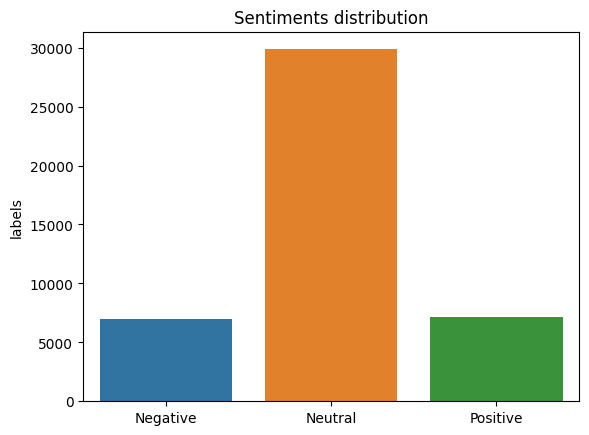

In [29]:
# Visualize distribution
distribution = sns.barplot(x=train_df.labels.value_counts().index, y=train_df.labels.value_counts())
distribution.set(title="Sentiments distribution", xticklabels=['Negative', 'Neutral', 'Positive']);

Neutral examples are much more than the others, so I will use a weighted loss function during training

In [42]:
# Get class weights
class_weights = (1 - dataset.labels.value_counts().sort_index() / len(dataset)).values
class_weights = torch.from_numpy(class_weights).float().to("cuda")
class_weights

tensor([0.8396, 0.3207, 0.8396], device='cuda:0')

In [43]:
# Define custom trainer
class WeightedLossTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    # Feed inputs to model & extract logits (forward pass)
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # Extract labels
    labels = inputs.get("labels")
    # Define weighted loss function
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    # Compute loss
    loss = loss_fn(logits, labels)
    return (loss, outputs) if return_outputs else loss

In [44]:
# Define metrics
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  return {'f1': f1}

In [62]:
# Tokenize text data
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02-twitter")

t = Dataset.from_pandas(train_df)
v = Dataset.from_pandas(val_df)

def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True, padding=True)
 
tokenized_train = t.map(preprocess_function, batched=True)
tokenized_test = v.map(preprocess_function, batched=True)

Map:   0%|          | 0/44000 [00:00<?, ? examples/s]

Map:   0%|          | 0/11000 [00:00<?, ? examples/s]

In [63]:
tokenized_train

Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 44000
})

In [47]:
# Load pretrained model
model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv02-twitter", 
                                                           num_labels=3,
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmi

In [51]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [64]:
# Defining training arguments
training_args = TrainingArguments(
    output_dir='.',
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    fp16=True
)

# Defining trainer
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Training the model
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.461900,0.395909,0.831091
2,0.365000,0.406336,0.829044
3,0.282400,0.426491,0.828330


TrainOutput(global_step=2064, training_loss=0.3557900624681813, metrics={'train_runtime': 1789.7736, 'train_samples_per_second': 73.752, 'train_steps_per_second': 1.153, 'total_flos': 1.2903197117501376e+16, 'train_loss': 0.3557900624681813, 'epoch': 3.0})

In [65]:
trainer.evaluate()

{'eval_loss': 0.426490843296051,
 'eval_f1': 0.8283301772587127,
 'eval_runtime': 19.4268,
 'eval_samples_per_second': 566.229,
 'eval_steps_per_second': 8.854,
 'epoch': 3.0}